* This notebook was made to create TS initial files based on 21apr15 to spinup for May2015.

In [1]:
from __future__ import division, print_function
from salishsea_tools import (nc_tools,viz_tools,tidetools,bathy_tools)
from nowcast import figures
import scipy.io as sio
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
%matplotlib inline

In [2]:
#old initial file
initial_path = '/results/SalishSea/nowcast/21apr15/SalishSea_1h_20150421_20150421_grid_T.nc'
T_S = nc.Dataset(initial_path, 'r')

In [3]:
#nc_tools.show_variables(T_S)
old_T = T_S.variables['votemper'][0] # omit the first dimension
old_S = T_S.variables['vosaline'][0]
depths = T_S.variables['deptht']
lon = T_S.variables['nav_lon']
lat = T_S.variables['nav_lat']

In [4]:
#read in new bathymetry
new_path = '/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc'
Fraser = nc.Dataset(new_path, 'r')
bathy = Fraser.variables['Bathymetry'][:]

In [5]:
floor = np.empty_like(depths)
ceil = np.empty_like(depths)
ceil[0] = 0.
floor[0] = 2*depths[0]
for k in range(1,40):
    ceil[k] = floor[k-1]
    floor[k] = 2*depths[k] -floor[k-1]

In [6]:
S = np.empty_like(old_S)
T = np.empty_like(old_T)
#for every cell with top of cell depth < bathymetry, use old TS, if old TS=0, find closest point and use that.
for k in range(40):
    for j in range(398):
        for i in range(898):
            if ceil[k] < bathy[i,j]:
                if old_S[k,i,j] != 0:
                    S[k,i,j] = old_S[k, i, j]
                    T[k,i,j] = old_T[k, i, j]
                else:
                    # closest neighbour thing
                    masked_array = np.ma.array(old_S[k], mask = old_S[k] == 0)
                    X, Y = tidetools.find_closest_model_point(lon[i,j], lat[i,j], lon, lat, masked_array)
                    S[k, i, j] = old_S[k, X, Y]
                    T[k, i, j] = old_T[k, X, Y]

In [7]:
# build nc file
new_TS = nc.Dataset('TSApr21.nc', 'w')
nc_tools.init_dataset_attrs(
    new_TS, 
    title='Salinity Temperature Initial Conditions based on 21apr15 nowcast run restart file', 
    notebook_name='CreateTSforMay2105', 
    nc_filepath='/ocean/jieliu/research/meopar/nemo-forcing/initial_strat/TSApr21.nc',
    comment='Salinity and Temperature conditions from 11apr20apr spin-up run restart file onto north extended Fraser bathymetry6')
new_TS.createDimension('y', 898)
new_TS.createDimension('x', 398)
new_TS.createDimension('deptht',size = len(depths))
new_TS.createDimension('time_counter', None)
#nc_tools.show_dimensions(new_TS)
# show variables
nav_lat = new_TS.createVariable('nav_lat', 'float32', ('y','x'))
nav_lat.long_name = 'Latitude'
nav_lat.units = 'degrees_north'
nav_lat = lat
nav_lon = new_TS.createVariable('nav_lon', 'float32', ('y','x'))
nav_lon.long_name = 'Longitude'
nav_lon.units = 'degrees_east'
nav_lon = lon
deptht = new_TS.createVariable('deptht', 'float32', ('deptht'))
deptht.long_name = 'Depth'
deptht.units = 'm'
deptht.positive = 'down'
deptht.valid_range = np.array((4., 428.))##minimum depth 4m
deptht = depths
time_counter = new_TS.createVariable('time_counter', 'float32', ('time_counter'))
time_counter.units = 'seconds since 11apr20apr'
time_counter.long_name = 'Time axis'
vosaline = new_TS.createVariable('vosaline', 'float32', 
                               ('time_counter','deptht','y','x'))
vosaline.units = 'none'
vosaline.long_name = 'Practical Salinity'  
vosaline.coordinates = 'nav_lon nav_lat deptht time_counter'
vosaline.grid = 'SalishSea6, north extended Fraser'
vosaline[0] = S
votemper = new_TS.createVariable('votemper', 'float32', 
                               ('time_counter','deptht','y','x'))
votemper.units = 'degC'
votemper.long_name = 'Temperature' 
votemper.coordinates = 'nav_lon nav_lat deptht time_counter'
votemper[0] = T
new_TS.history = """[2015-06-14] Created"""

file format: NETCDF4
Conventions: CF-1.6
title: Salinity Temperature Initial Conditions based on 21apr15 nowcast run restart file
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: REQUIRED
references: REQUIRED
history: [2016-01-07 16:08:23] Created netCDF4 zlib=True dataset.
comment: Salinity and Temperature conditions from 11apr20apr spin-up run restart file onto north extended Fraser bathymetry6


/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


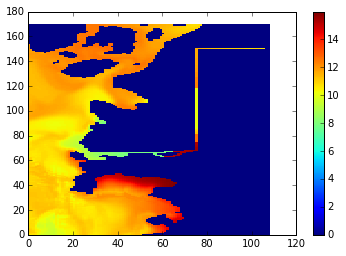

In [8]:
## temperature before
plt.pcolormesh(votemper[0,0, 350: 520, 290 : 398])
plt.colorbar()

In [21]:
## modify temperature for some grid cells
k = 0 
i = 413
j = 351
votemper[0,  : , i, j : j + 5] = 8. ## for(413, 351:355) from 0 to 4m
votemper[0,  : , i + 4, j + 4: j +13] = 8. ## for (417, 355:363).. ..
votemper[0,  : , i + 1, j + 4: j + 7] = 8. ## for (414, 355:357).. ..
votemper[0,  : , i + 2, j + 6: j + 8] = 8. ## for (415, 357:358).. ..
votemper[0,  : , i + 3, j + 7: j + 10] = 8. ## for (416, 358:360).. ..
votemper[0,  : , i + 5, j + 9: j + 15] = 8. ## for (418, 360:365).. ..
## plus north ones(all depth):
votemper[0, k : , i + 5 : i + 88,  j + 14] = 8. ## for (418-500, 365).. ..
votemper[0, k : ,  i + 87,  j+ 14 : j + 45] = 8. ## for (500, 365-395)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


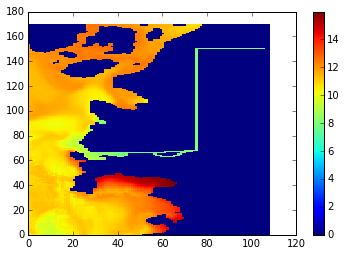

In [22]:
## temperature after
plt.pcolormesh(votemper[0,0, 350: 520, 290 : 398])
plt.colorbar()

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


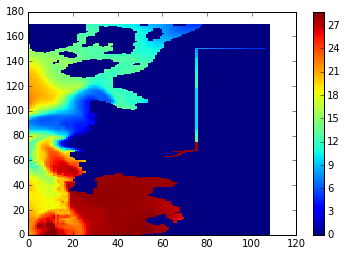

In [9]:
## salinity before
plt.pcolormesh(vosaline[0,0, 350: 520, 290 : 398])
plt.colorbar()

In [10]:
## set salinity after New Westminster as 1,before as 0,river source cell as 0
k = 0 
i = 418
j = 365
vosaline[0,  :, i-2, j-30: j-13] = 0.#16,335:351)(416 ,358:360)
vosaline[0,  :, i -2, j -7: j -4] = 0.
vosaline[0,  :, i -1,j -14:j -1] = 0.#(417, 351:363)..  ..
vosaline[0,  :, i - 4, j - 18: j - 15] = 0.## for (414, 347:349)( 414, 355:357).. ..
vosaline[0,  :, i - 4, j - 10: j - 7] = 0.
vosaline[0,  :, i - 5,j - 16:j- 9]=0.## for (413, 349:355)
vosaline[0,  :, i - 3, j  - 19:j-17] =0.#(415, 346, 347, 357, 358).. ..
vosaline[0,  :, i - 3, j  - 8: j - 6] = 0.
vosaline[0,  :, i , j -5 : j +1] = 0.#for(418,360:365) .. ..New Westminster
## plus north ones(all depth):
vosaline[0,  : , i: i+ 83 ,  j]  = 0. ## for (418-500, 365).. ..
vosaline[0,  : ,  i + 82,  j : j + 30] = 0. ## for (500, 365-394)

In [11]:
## make salinity(500, 395)==0(source) for all depth
vosaline[0,  : ,  500,  395] = 0.

In [12]:
## make original salinity of freshwater source point as 4
vosaline[0, 0:4 , 416, 334] = 1.

In [13]:
## modify damp salinity values but not for the widen part
k = 0; i = 425; j = 302; d = 1.
vosaline[0, k: k +4, i, j+1] = d
vosaline[0, k: k +4, i-1, j:j+3] = d
vosaline[0, k: k +4, i-2, j+1:j+5] = d
vosaline[0, k: k +4, i-3, j+3:j+7] = d
vosaline[0, k: k +4, i-4, j+5:j+9] = d
vosaline[0, k: k +4, i-5, j+7:j+11] = d
vosaline[0, k: k +4, i-6, j+9:j+13] = d
vosaline[0, k: k +4, i-7, j+11:j+14] = d
vosaline[0, k: k +4, i-8, j+12:j+16] = d

In [14]:
## modify salinity values of straight channel connect damp and further extended channel
k = 0; i = 416; j = 317; d= 1.
vosaline[0, k : k +4, i, j-1:j+18] = d

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


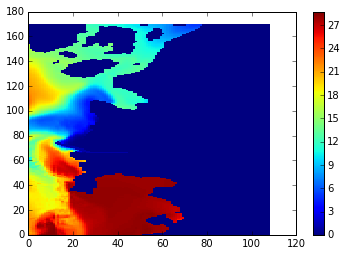

In [15]:
## salinity after
plt.pcolormesh(vosaline[0,0, 350: 520, 290 : 398])
plt.colorbar()

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


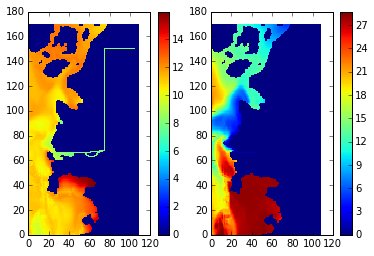

In [23]:
plt.subplot(1, 2, 1)
plt.pcolormesh(votemper[0,0, 350: 520, 290 : 398])
plt.colorbar()
plt.subplot(1, 2, 2)
plt.pcolormesh(vosaline[0,0, 350: 520, 290 : 398])
plt.colorbar()

In [24]:
new_TS.close()